# NBA Regular Season Success Analysis: Financial Strategies and Roster Engineering

## 1. Project Overview
This project analyzes the key factors influencing the **regular season** success of NBA teams during the 2024-2025 season. Deviating from pure on-court analytics, this study focuses on **"front office" decisions**.

Under the constraints of the Salary Cap and the new CBA (Collective Bargaining Agreement), we statistically examine how financial allocation, roster stability, and age demographics impact winning.

### Objectives
1.  **Financial Strategies:** Analyze the impact of `Top3_Salary_Share` and `Luxury_Tax` on success.
2.  **Roster Engineering:** Quantify the role of `Minutes_Continuity` and `Avg_Age`.
3.  **Inefficiency:** Measure the drag caused by `Dead_Money`.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid", context="notebook", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'sans-serif'

print(" Libraries Imported Successfully.")

 Libraries Imported Successfully.


## 2. Data Loading and Cleaning
The dataset consists of 30 NBA teams with variables aggregated from the 2024-2025 regular season.
* **Source:** Basketball-Reference, Spotrac.
* **Key Metrics:** Win Percentage, Salary Cap Data, Continuity, and Advanced Ratings.

In [4]:
df = pd.read_csv('dsa.csv')

df.columns = [c.strip() for c in df.columns]

display(df.head())

print(f"Dataset Shape: {df.shape[0]} Teams, {df.shape[1]} Features")

,Rank,Team,Wins,Losses,Win_Percentage,Defensive_Rating,Avg_Age,Avg_Age_perMinute,Minutes_Continuity,Total_Cap_Allocated,Active_Cap,Luxury_Tax_Bill,Active_Top3_Cap,Top3_Salary_Share,Dead_Cap,Dead_Money_Share,Season
0,1,OKC,68,14,0.829268,107.5,24.2,25.5,79,166001694,162209242,0.0,82859950,0.589381,3792452,0.026976,2025
1,2,CLE,64,18,0.780488,112.2,26.0,27.0,92,178212347,169371096,0.0,93832409,0.667428,491175,0.003494,2025
2,3,BOS,61,21,0.743902,111.1,27.5,27.2,97,197048229,193098445,66664570.0,114054140,0.811265,0,0.000000,2025
3,4,HOU,52,30,0.634146,110.8,25.7,26.6,92,173496349,161552948,0.0,78702108,0.559807,7768363,0.055256,2025
4,5,NYK,51,31,0.621951,114.3,26.5,29.1,57,188877651,188001268,14976511.0,110803733,0.788145,876383,0.006234,2025


Dataset Shape: 30 Teams, 17 Features


## 3. Exploratory Data Analysis (EDA)

Before hypothesis testing, we examine the distribution and statistical summary of our independent and dependent variables.

In [5]:
eda_vars = ['Win_Percentage', 'Top3_Salary_Share', 'Luxury_Tax_Bill', 
            'Minutes_Continuity', 'Defensive_Rating', 'Dead_Money_Share', 'Avg_Age']

desc_stats = df[eda_vars].describe().T[['count', 'mean', 'std', 'min', '50%', 'max']]
display(desc_stats)

,count,mean,std,min,50%,max
Win_Percentage,30.0,5.000000e-01,1.628607e-01,0.207317,0.493902,8.292683e-01
Top3_Salary_Share,30.0,6.909490e-01,1.595221e-01,0.402303,0.676799,1.071135e+00
Luxury_Tax_Bill,30.0,1.735316e+07,4.063770e+07,0.000000,0.000000,1.883038e+08
Minutes_Continuity,30.0,6.810000e+01,1.469072e+01,38.000000,67.000000,9.700000e+01
Defensive_Rating,30.0,1.141900e+02,3.412083e+00,107.000000,114.500000,1.204000e+02
Dead_Money_Share,30.0,4.476948e-02,7.679214e-02,0.000000,0.026459,4.154615e-01
Avg_Age,30.0,2.576667e+01,1.272070e+00,23.800000,25.700000,2.810000e+01


### Correlation Matrix
Visualizing the relationships between financial/roster metrics and winning percentage.

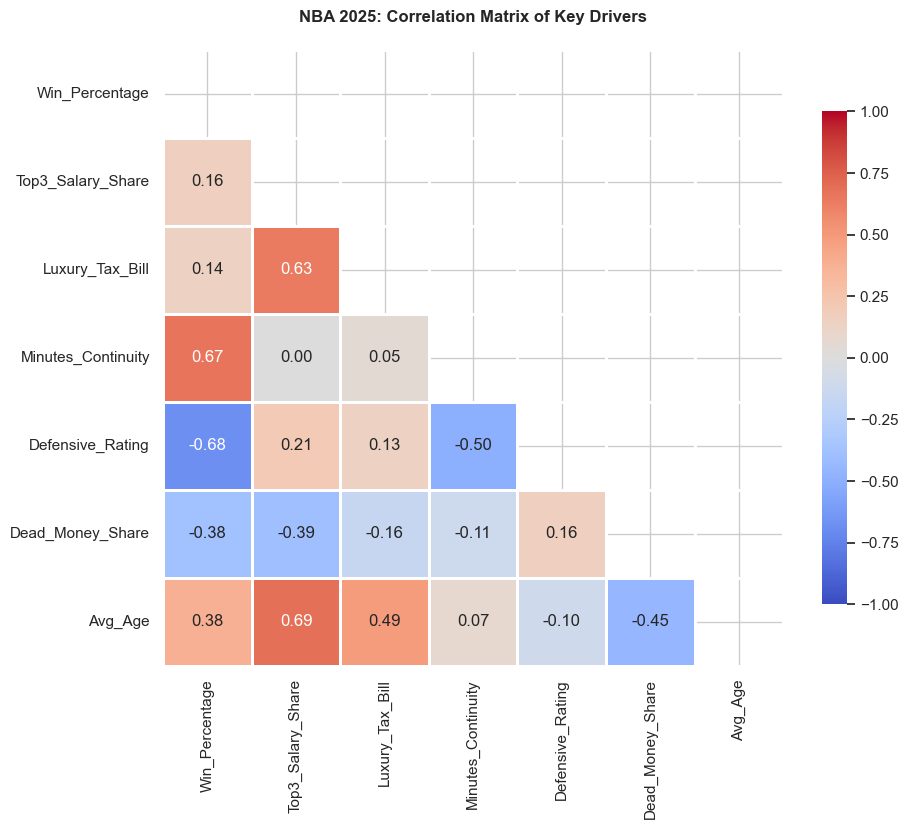

In [6]:
plt.figure(figsize=(10, 8))
corr_matrix = df[eda_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=1, vmin=-1, vmax=1, cbar_kws={"shrink": .8})

plt.title('NBA 2025: Correlation Matrix of Key Drivers', fontweight='bold', pad=20)
plt.show()

### Helper Functions for Visualization
Defining custom plotting functions to handle team annotations and varied chart types.

In [7]:
def add_team_labels(df, x_col, y_col, ax, offset=0.002):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].iloc[i], y=df[y_col].iloc[i], s=df['Team'].iloc[i], 
                fontdict=dict(color='black', size=9, weight='bold'),
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

def plot_hypothesis_scatter(df, x_col, y_col, title, x_label):
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    sns.regplot(data=df, x=x_col, y=y_col, ci=None, ax=ax,
                scatter_kws={'s':100, 'alpha':0.6, 'color':'#3498db'}, 
                line_kws={'color':'red', 'ls':'--', 'lw':2})
    add_team_labels(df, x_col, y_col, ax)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_label)
    plt.ylabel("Win Percentage")
    plt.grid(True, alpha=0.3)
    plt.show()

print(" Helper functions defined.")

 Helper functions defined.


## 4. Hypothesis Testing

### Hypothesis 1: Financial Strategies (Superstars)
Does concentrating salary in 2-3 superstars yield a higher return in wins?

* **$H_0$**: There is no significant relationship between `Top3_Salary_Share` and `Win_Percentage`.
* **$H_1$**: There is a positive relationship; teams that spend more on top stars win more.

HYPOTHESIS 1: SUPERSTAR SALARY ALLOCATION

Pearson Correlation Coefficient: 0.1571
P-value: 0.4072

CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS
Interpretation: Allocating cap space to superstars does not significantly predict regular season success.


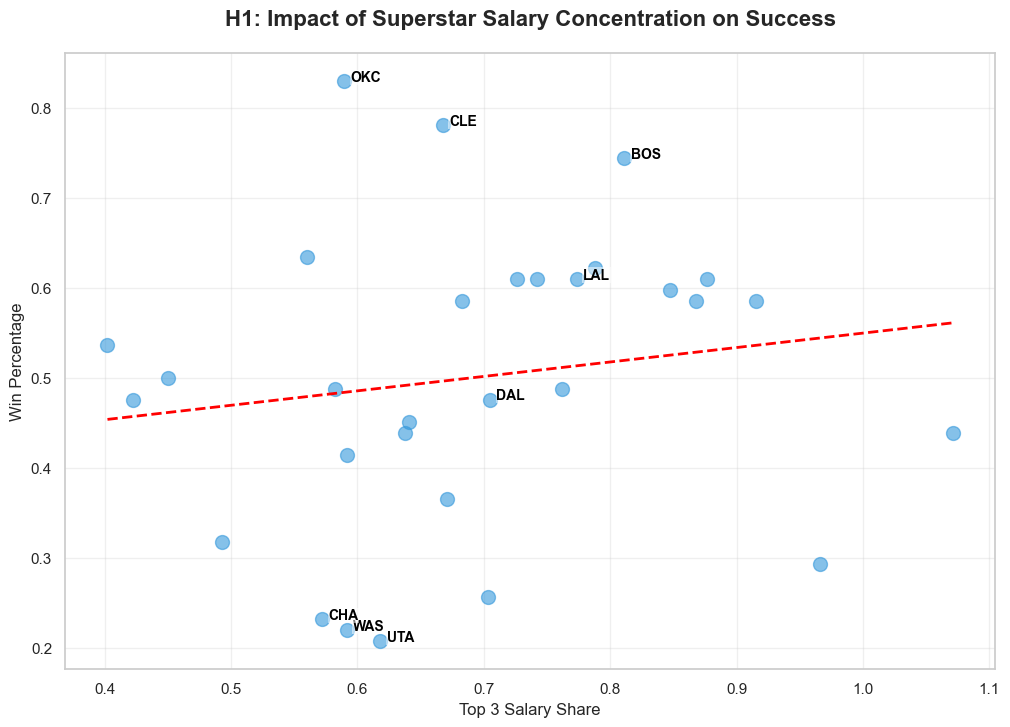

In [8]:
r, p = stats.pearsonr(df['Top3_Salary_Share'], df['Win_Percentage'])

print("HYPOTHESIS 1: SUPERSTAR SALARY ALLOCATION")
print("")
print(f"Pearson Correlation Coefficient: {r:.4f}")
print(f"P-value: {p:.4f}")
print("")

if p < 0.05:
    print("CONCLUSION: REJECT THE NULL HYPOTHESIS")
    print("Interpretation: There is a statistically significant correlation between top 3 salary share and winning.")
else:
    print("CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Allocating cap space to superstars does not significantly predict regular season success.")


plt.figure(figsize=(12, 8))

sns.regplot(data=df, x='Top3_Salary_Share', y='Win_Percentage', ci=None, 
            scatter_kws={'s':100, 'alpha':0.6, 'color':'#3498db'}, 
            line_kws={'color':'red', 'ls':'--', 'lw':2})

df_sorted = df.sort_values('Win_Percentage')
labels = pd.concat([df_sorted.head(3), df_sorted.tail(3), df_sorted.sample(2)])

for i in range(len(labels)):
    plt.text(x=labels['Top3_Salary_Share'].iloc[i]+0.005, 
             y=labels['Win_Percentage'].iloc[i], 
             s=labels['Team'].iloc[i], 
             fontdict=dict(color='black', size=10, weight='bold'),
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))

plt.title("H1: Impact of Superstar Salary Concentration on Success", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Top 3 Salary Share", fontsize=12)
plt.ylabel("Win Percentage", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Hypothesis 2: Luxury Tax Impact
Is paying the luxury tax a statistically significant predictor of regular season success?

* **$H_0$**: Paying Luxury Tax has no effect on `Win_Percentage`.
* **$H_1$**: Paying Luxury Tax is positively correlated with `Win_Percentage`.

HYPOTHESIS 2: LUXURY TAX IMPACT

T-Statistic: 1.1082
P-value: 0.2772

CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS
Interpretation: Paying luxury tax does not yield a statistically significant advantage.


/var/folders/fw/0md5k1tx1mz3x_2f2jttqrjc0000gn/T/ipykernel_12649/711512225.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tax_Payer', y='Win_Percentage', data=df, palette="Set3", showfliers=False)


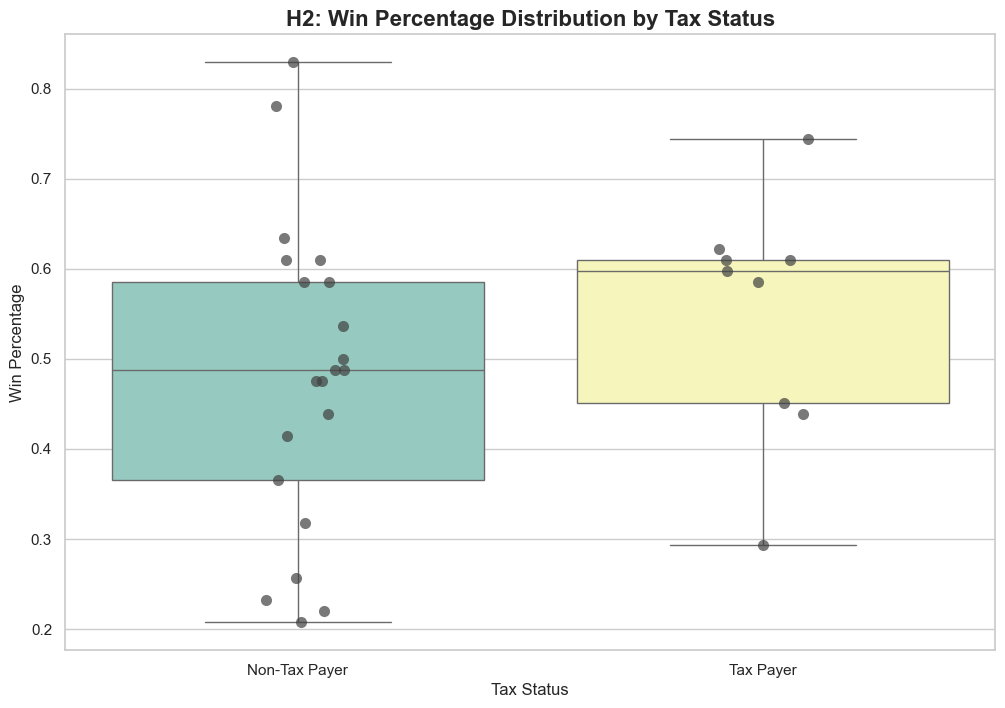

In [9]:
df['Tax_Payer'] = np.where(df['Luxury_Tax_Bill'] > 0, 'Tax Payer', 'Non-Tax Payer')

payers = df[df['Tax_Payer'] == 'Tax Payer']['Win_Percentage']
non_payers = df[df['Tax_Payer'] == 'Non-Tax Payer']['Win_Percentage']
t_stat, p_val = stats.ttest_ind(payers, non_payers)

print("HYPOTHESIS 2: LUXURY TAX IMPACT")
print("")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print("")

if p_val < 0.05:
    print("CONCLUSION: REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Teams paying luxury tax have statistically different win rates.")
else:
    print("CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Paying luxury tax does not yield a statistically significant advantage.")

plt.figure(figsize=(12, 8))

sns.boxplot(x='Tax_Payer', y='Win_Percentage', data=df, palette="Set3", showfliers=False)
sns.stripplot(x='Tax_Payer', y='Win_Percentage', data=df, color=".25", size=8, alpha=0.7)

plt.title("H2: Win Percentage Distribution by Tax Status", fontsize=16, fontweight='bold')
plt.ylabel("Win Percentage")
plt.xlabel("Tax Status")
plt.show()

### Hypothesis 3: Roster Engineering (Continuity)
What is the quantitative impact of "roster chemistry," as measured by `Minutes_Continuity`?

* **$H_0$**: Roster continuity implies no change in success.
* **$H_1$**: Higher `Minutes_Continuity` is positively correlated with `Win_Percentage`.

HYPOTHESIS 3: ROSTER CONTINUITY

Pearson Correlation Coefficient: 0.6714
P-value: 0.0000

CONCLUSION: REJECT THE NULL HYPOTHESIS
Interpretation: Roster continuity is a significant predictor of regular season success.


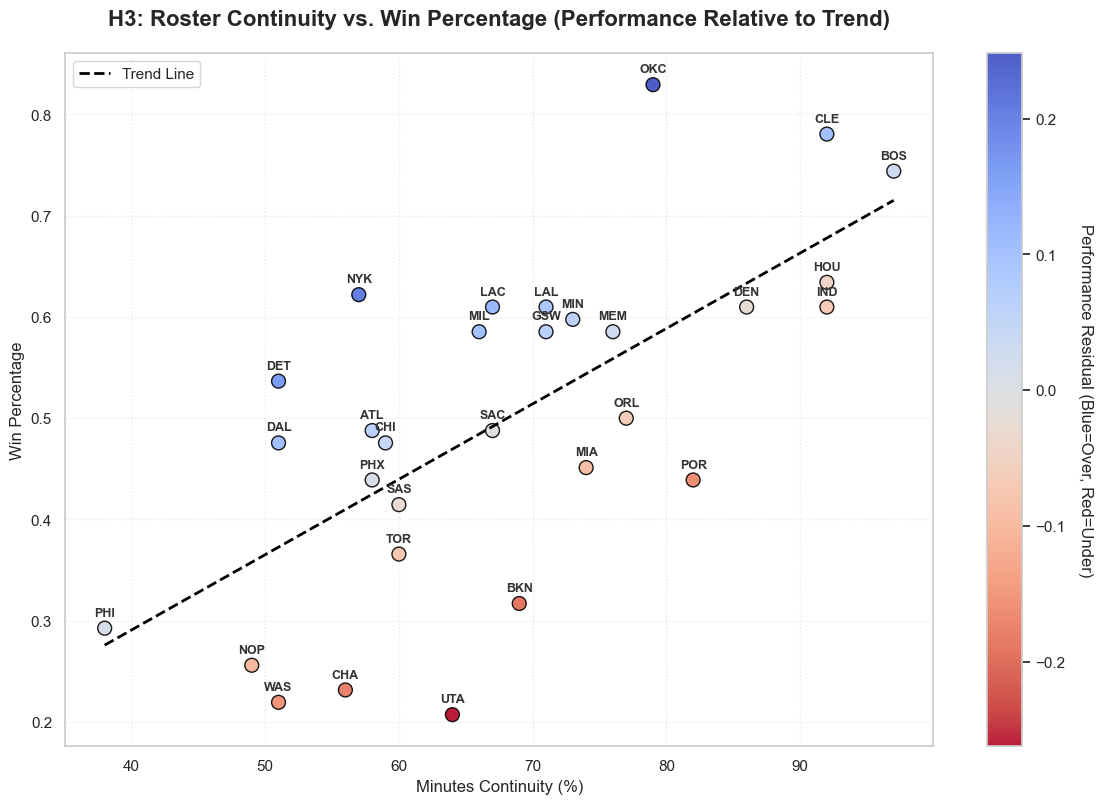

In [10]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Minutes_Continuity'], df['Win_Percentage'])
df['Predicted_Win_Pct'] = slope * df['Minutes_Continuity'] + intercept
df['Residual'] = df['Win_Percentage'] - df['Predicted_Win_Pct'] 

print("HYPOTHESIS 3: ROSTER CONTINUITY")
print("")
print(f"Pearson Correlation Coefficient: {r_value:.4f}")
print(f"P-value: {p_value:.4f}")
print("")
if p_value < 0.05:
    print("CONCLUSION: REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Roster continuity is a significant predictor of regular season success.")
else:
    print("CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS")

plt.figure(figsize=(14, 9))

points = plt.scatter(df['Minutes_Continuity'], df['Win_Percentage'], 
                     c=df['Residual'], cmap='coolwarm_r', s=100, edgecolors='black', alpha=0.9)

x_vals = np.array([df['Minutes_Continuity'].min(), df['Minutes_Continuity'].max()])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2, label='Trend Line')

for i in range(len(df)):
    plt.text(x=df['Minutes_Continuity'].iloc[i], 
             y=df['Win_Percentage'].iloc[i] + 0.012, 
             s=df['Team'].iloc[i], 
             fontsize=9, fontweight='bold', color='#333333',
             ha='center')

plt.title("H3: Roster Continuity vs. Win Percentage (Performance Relative to Trend)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Minutes Continuity (%)", fontsize=12)
plt.ylabel("Win Percentage", fontsize=12)

cbar = plt.colorbar(points)
cbar.set_label('Performance Residual (Blue=Over, Red=Under)', rotation=270, labelpad=20)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()

### Hypothesis 4: Experience and Defense
Do veteran teams demonstrate empirically superior defensive performance?

* **$H_0$**: There is no relationship between `Avg_Age` and `Defensive_Rating`.
* **$H_1$**: There is a **negative** relationship (Older age -> Lower/Better Def Rating).

HYPOTHESIS 4: EXPERIENCE AND DEFENSE

Pearson Correlation Coefficient: -0.1042
P-value: 0.5836

CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS



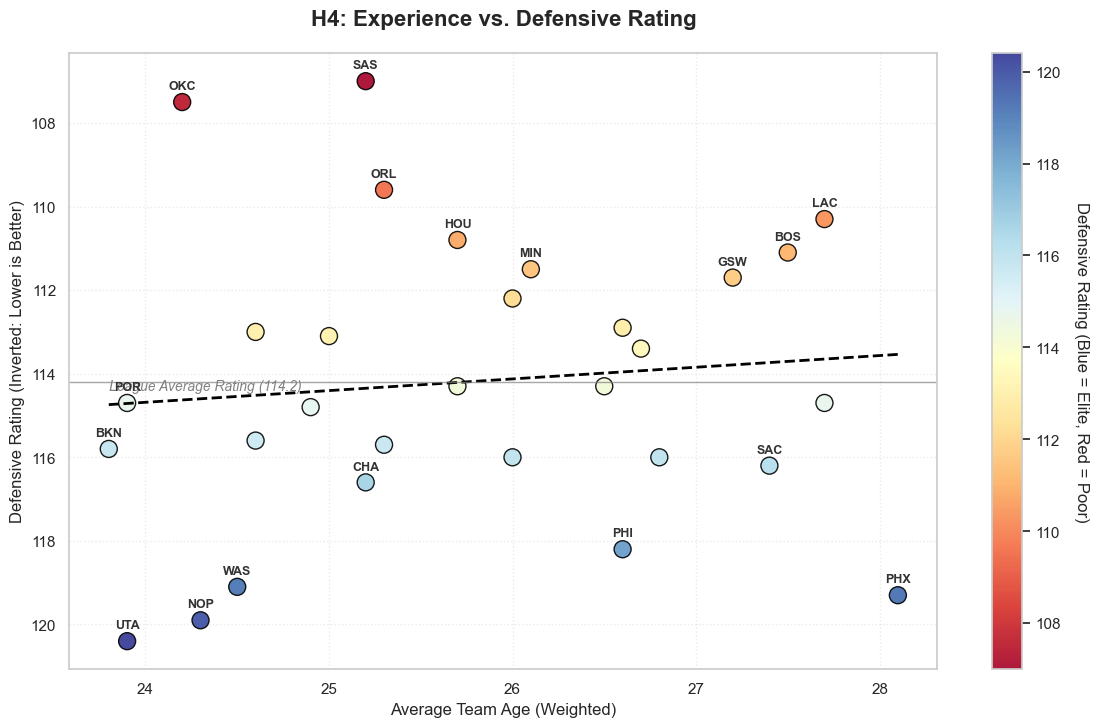

In [11]:
r, p = stats.pearsonr(df['Avg_Age'], df['Defensive_Rating'])

print("HYPOTHESIS 4: EXPERIENCE AND DEFENSE")
print("")
print(f"Pearson Correlation Coefficient: {r:.4f}")
print(f"P-value: {p:.4f}")
print("")
if p < 0.05:
    print("CONCLUSION: REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Older teams demonstrate statistically superior defensive ratings.")
else:
    print("CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS")
print("")
plt.figure(figsize=(14, 8))

sc = plt.scatter(df['Avg_Age'], df['Defensive_Rating'], 
                 c=df['Defensive_Rating'], cmap='RdYlBu', s=150, edgecolors='black', alpha=0.9)

sns.regplot(data=df, x='Avg_Age', y='Defensive_Rating', scatter=False, 
            color='black', line_kws={'linestyle': '--', 'linewidth': 2}, ci=None)

avg_def = df['Defensive_Rating'].mean()
plt.axhline(avg_def, color='gray', linestyle='-', linewidth=1, alpha=0.7)
plt.text(df['Avg_Age'].min(), avg_def + 0.2, f'League Average Rating ({avg_def:.1f})', 
         color='gray', fontsize=10, fontstyle='italic')

for i in range(len(df)):
    dist_from_avg = abs(df['Defensive_Rating'].iloc[i] - avg_def)
    
    if dist_from_avg > 2.0 or df['Avg_Age'].iloc[i] > 28 or df['Avg_Age'].iloc[i] < 24:
        plt.text(x=df['Avg_Age'].iloc[i], 
                 y=df['Defensive_Rating'].iloc[i] - 0.3, 
                 s=df['Team'].iloc[i], 
                 fontsize=9, fontweight='bold', color='#333333', ha='center')

plt.title("H4: Experience vs. Defensive Rating", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Average Team Age (Weighted)", fontsize=12)
plt.ylabel("Defensive Rating (Inverted: Lower is Better)", fontsize=12)
plt.gca().invert_yaxis()

cbar = plt.colorbar(sc)
cbar.set_label('Defensive Rating (Blue = Elite, Red = Poor)', rotation=270, labelpad=20)
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()

### Hypothesis 5: The "Dead Money" Drag
What is the "cost" of bad contracts?

* **$H_0$**: Dead Money has no impact on winning.
* **$H_1$**: There is a negative relationship between `Dead_Money_Share` and `Win_Percentage`.

HYPOTHESIS 5: DEAD MONEY BURDEN

Spearman Rank Correlation: -0.4116
P-value: 0.0238

CONCLUSION: REJECT THE NULL HYPOTHESIS
Interpretation: Significant negative correlation between dead money and winning.


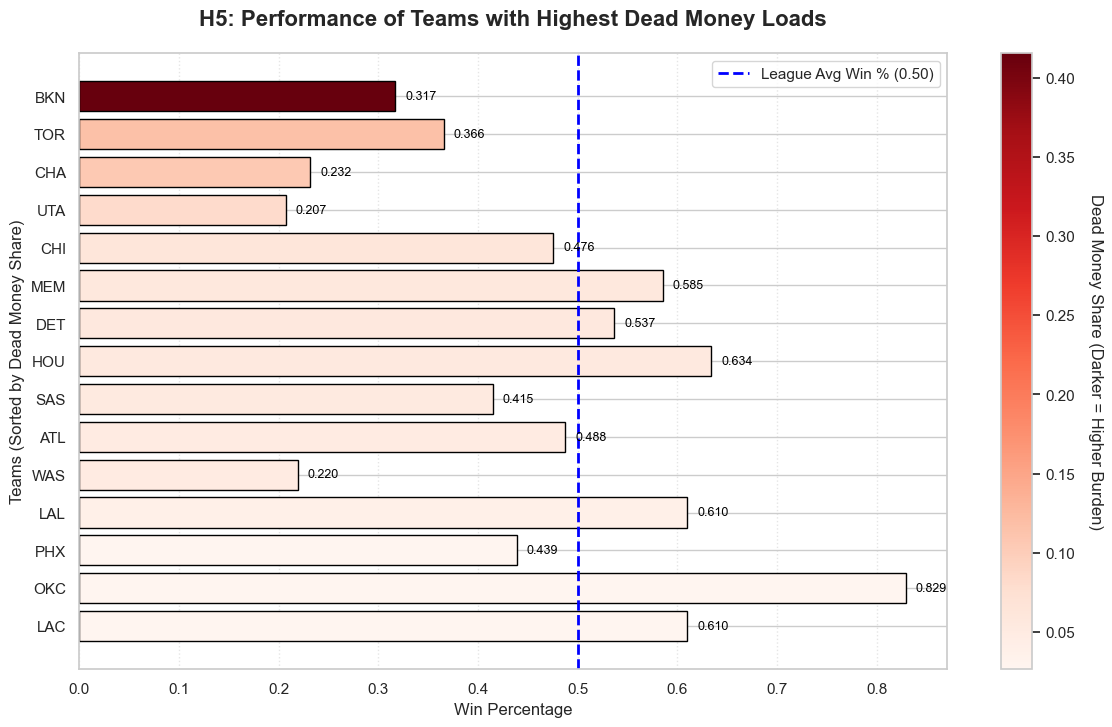

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy import stats 

r_s, p_s = stats.spearmanr(df['Dead_Money_Share'], df['Win_Percentage'])

print("HYPOTHESIS 5: DEAD MONEY BURDEN")
print("")
print(f"Spearman Rank Correlation: {r_s:.4f}")
print(f"P-value: {p_s:.4f}")
print("")

if p_s < 0.05:
    print("CONCLUSION: REJECT THE NULL HYPOTHESIS")
    print("Interpretation: Significant negative correlation between dead money and winning.")
else:
    print("CONCLUSION: FAIL TO REJECT THE NULL HYPOTHESIS")

plt.figure(figsize=(14, 8))

df_dead = df[df['Dead_Money_Share'] > 0].sort_values('Dead_Money_Share', ascending=False).head(15)

norm = mcolors.Normalize(vmin=df_dead['Dead_Money_Share'].min(), vmax=df_dead['Dead_Money_Share'].max())
mapper = cm.ScalarMappable(norm=norm, cmap='Reds')

bar_colors = mapper.to_rgba(df_dead['Dead_Money_Share'])

bars = plt.barh(df_dead['Team'], df_dead['Win_Percentage'], color=bar_colors, edgecolor='black')

avg_win = df['Win_Percentage'].mean()
plt.axvline(avg_win, color='blue', linestyle='--', linewidth=2, label=f'League Avg Win % ({avg_win:.2f})')

plt.title("H5: Performance of Teams with Highest Dead Money Loads", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Win Percentage", fontsize=12)
plt.ylabel("Teams (Sorted by Dead Money Share)", fontsize=12)
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', va='center', fontsize=9, color='black')

cbar = plt.colorbar(mapper, ax=plt.gca())
cbar.set_label('Dead Money Share (Darker = Higher Burden)', rotation=270, labelpad=20)

plt.legend()
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.show()

## 6. Machine Learning Analysis: Feature Importance

In this final phase, we utilize Machine Learning algorithms to validate our statistical findings. By training a **Random Forest Regressor**, we can quantify the predictive power of each "Front Office" decision on the team's success (`Win_Percentage`).

* **Target Variable ($y$):** Win Percentage
* **Features ($X$):** Top 3 Salary Share, Luxury Tax Bill, Continuity, Defensive Rating, Average Age, Dead Money Share.
* **Goal:** To determine which factor is the strongest predictor of winning.

Machine Learning Model Analysis

Model R² Score: 0.2525
Interpretation: Our model explains 25.3% of the variance in winning.


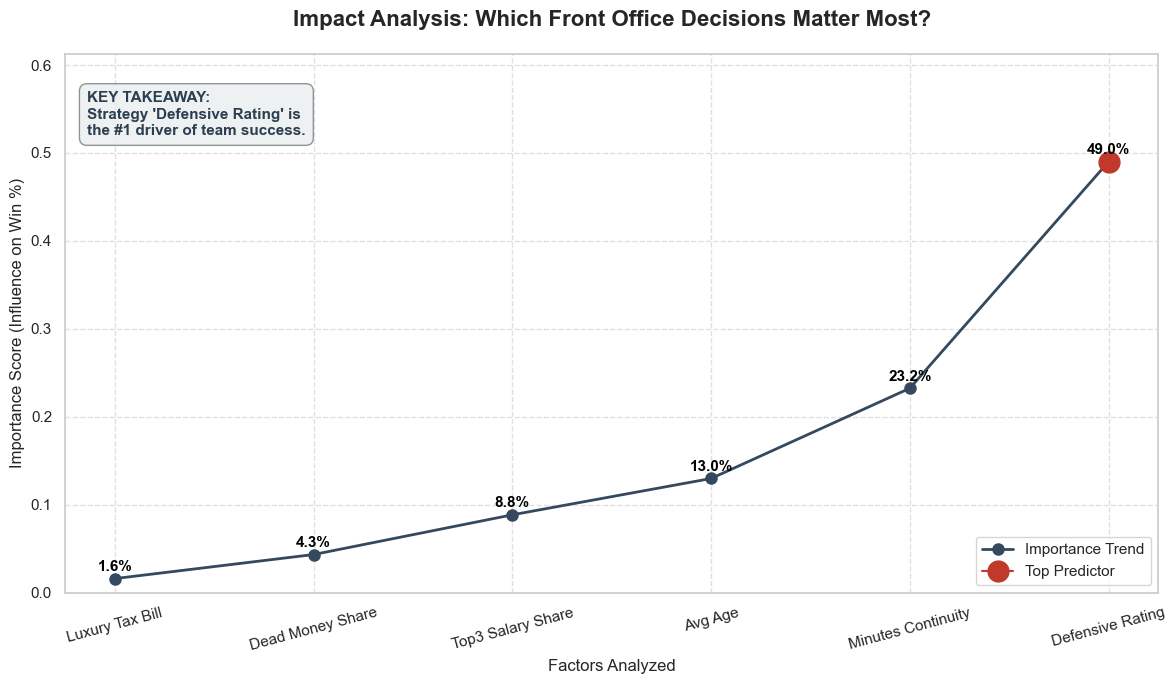

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

df = pd.read_csv('dsa.csv')
df.columns = [c.strip() for c in df.columns]

target = 'Win_Percentage'
features = ['Top3_Salary_Share', 'Luxury_Tax_Bill', 'Minutes_Continuity', 
            'Defensive_Rating', 'Avg_Age', 'Dead_Money_Share']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("Machine Learning Model Analysis")
print("")
print(f"Model R² Score: {r2:.4f}")
print(f"Interpretation: Our model explains {r2*100:.1f}% of the variance in winning.")

importances = rf_model.feature_importances_
feature_names = [f.replace('_', ' ') for f in features] 

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(12, 7))

plt.plot(forest_importances.index, forest_importances.values, 
         color='#34495e',      
         marker='o',            
         linestyle='-',        
         linewidth=2, 
         markersize=8, 
         label='Importance Trend')

top_feature_name = forest_importances.index[-1]
top_feature_value = forest_importances.values[-1]

plt.plot(top_feature_name, top_feature_value, 
         marker='o', 
         markersize=15,         
         color='#c0392b',      
         label='Top Predictor') 

for x, y in zip(forest_importances.index, forest_importances.values):
    label_text = f"{y:.1%}"
    plt.text(x, y + 0.005, label_text, 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

plt.title("Impact Analysis: Which Front Office Decisions Matter Most?", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Importance Score (Influence on Win %)", fontsize=12)
plt.xlabel("Factors Analyzed", fontsize=12)
plt.xticks(rotation=15) 
plt.grid(True, linestyle='--', alpha=0.6)

plt.ylim(0, top_feature_value * 1.25)

plt.text(0.02, 0.85, 
         f"KEY TAKEAWAY:\nStrategy '{top_feature_name}' is\nthe #1 driver of team success.", 
         transform=plt.gca().transAxes, 
         fontsize=11, fontweight='bold', color='#2c3e50',
         bbox=dict(facecolor='#ecf0f1', alpha=0.9, edgecolor='#7f8c8d', boxstyle='round,pad=0.5'))

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()